In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests

def load_image_from_github(raw_url, grayscale=False):
    response = requests.get(raw_url)

    if response.status_code != 200:
        raise ValueError(f"Failed to download image. Status code: {response.status_code}")
    image_bytes = np.frombuffer(response.content, np.uint8)

    # Decode image
    if grayscale:
        img = cv.imdecode(image_bytes, cv.IMREAD_GRAYSCALE)
    else:
        img = cv.imdecode(image_bytes, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    if img is None:
        raise ValueError("cv.imdecode failed. URL may not point to an image.")

    return img


Q1)

In [ ]:
runway_url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/runway.png"

runway = load_image_from_github(runway_url, grayscale=True)

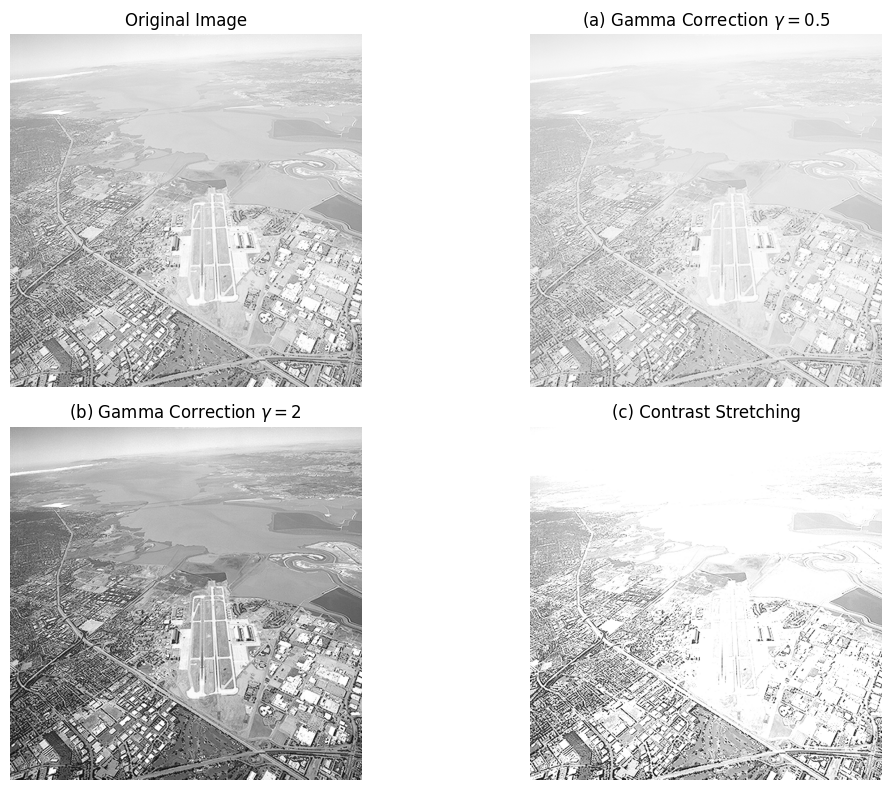

In [34]:
# Load runway image (grayscale)
img = runway.copy()

# Normalize to [0, 1]
r = img / 255.0

# (a) Gamma correction: γ = 0.5
gamma_a = 0.5
img_gamma_05 = np.uint8(np.clip(np.power(r, gamma_a) * 255, 0, 255))

# (b) Gamma correction: γ = 2.0
gamma_b = 2.0
img_gamma_2 = np.uint8(np.clip(np.power(r, gamma_b) * 255, 0, 255))

# (c) Contrast stretching
r1, r2 = 0.2, 0.8
s = np.zeros_like(r)

mask_mid = (r >= r1) & (r <= r2)
s[mask_mid] = (r[mask_mid] - r1) / (r2 - r1)
s[r > r2] = 1.0

img_contrast = np.uint8(np.clip(s * 255, 0, 255))

# Visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_gamma_05, cmap="gray")
plt.title(r"(a) Gamma Correction $\gamma=0.5$")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_gamma_2, cmap="gray")
plt.title(r"(b) Gamma Correction $\gamma=2$")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img_contrast, cmap="gray")
plt.title("(c) Contrast Stretching")
plt.axis("off")

plt.tight_layout()
plt.show()


Q2)

In [24]:
# Load the color highlights_and_shadows.jpg for Question 2
gamma_color_url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/highlights_and_shadows.jpg"

color_img = load_image_from_github(gamma_color_url, grayscale=False)


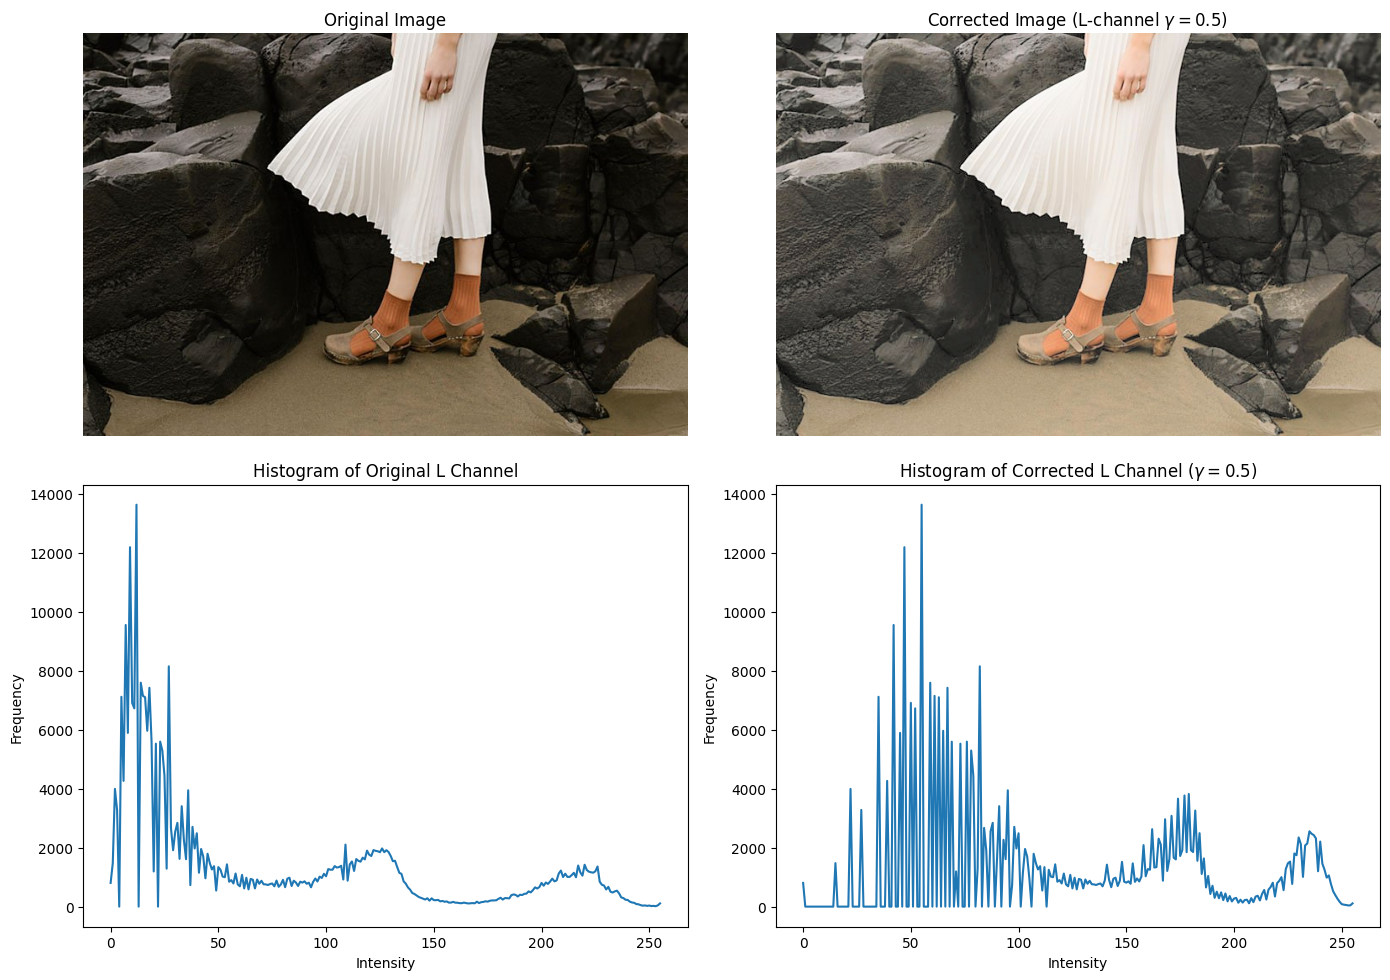

In [25]:
gamma_value = 0.5

# Convert RGB → LAB
img_lab = cv.cvtColor(color_img, cv.COLOR_RGB2LAB)
L, a, b = cv.split(img_lab)

# Gamma correction on L channel
L_norm = L / 255.0
L_gamma = np.uint8(np.clip(np.power(L_norm, gamma_value) * 255, 0, 255))

# Merge channels and convert back to RGB
lab_corrected = cv.merge((L_gamma, a, b))
img_corrected = cv.cvtColor(lab_corrected, cv.COLOR_LAB2RGB)

# Histograms
hist_L_orig = cv.calcHist([L], [0], None, [256], [0, 256])
hist_L_corr = cv.calcHist([L_gamma], [0], None, [256], [0, 256])

# Visualization
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.imshow(color_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_corrected)
plt.title(rf"Corrected Image (L-channel $\gamma={gamma_value}$)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.plot(hist_L_orig)
plt.title("Histogram of Original L Channel")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.plot(hist_L_corr)
plt.title(rf"Histogram of Corrected L Channel ($\gamma={gamma_value}$)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Q3)

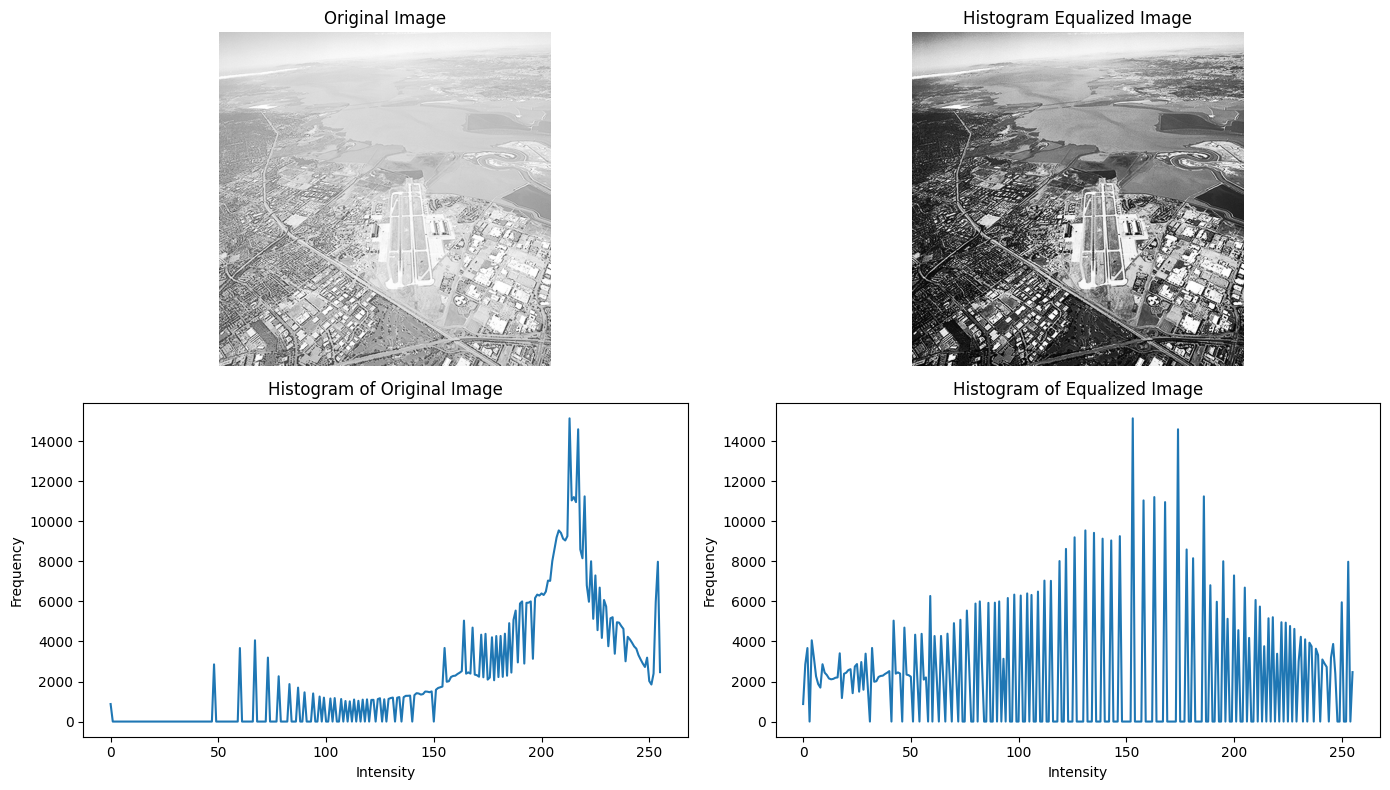

In [35]:
# Use the runway image
img = runway.copy()

# Manual histogram equalization function
def manual_hist_equalization(img):
    # Compute histogram
    hist = np.bincount(img.flatten(), minlength=256)

    # Compute cumulative distribution function (CDF)
    cdf = hist.cumsum()

    # Normalize CDF to [0, 255]
    cdf_normalized = (cdf - cdf.min()) / (cdf.max() - cdf.min())
    cdf_scaled = np.uint8(cdf_normalized * 255)

    # Map original image through CDF
    img_eq = cdf_scaled[img]

    return img_eq


# Apply histogram equalization to runway image
img_eq = manual_hist_equalization(runway)

# Histograms
hist_original = np.bincount(runway.flatten(), minlength=256)
hist_equalized = np.bincount(img_eq.flatten(), minlength=256)

# Visualization
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.imshow(runway, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_eq, cmap="gray")
plt.title("Histogram Equalized Image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.plot(hist_original)
plt.title("Histogram of Original Image")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.plot(hist_equalized)
plt.title("Histogram of Equalized Image")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Q4)

Otsu Threshold Value: 174.0


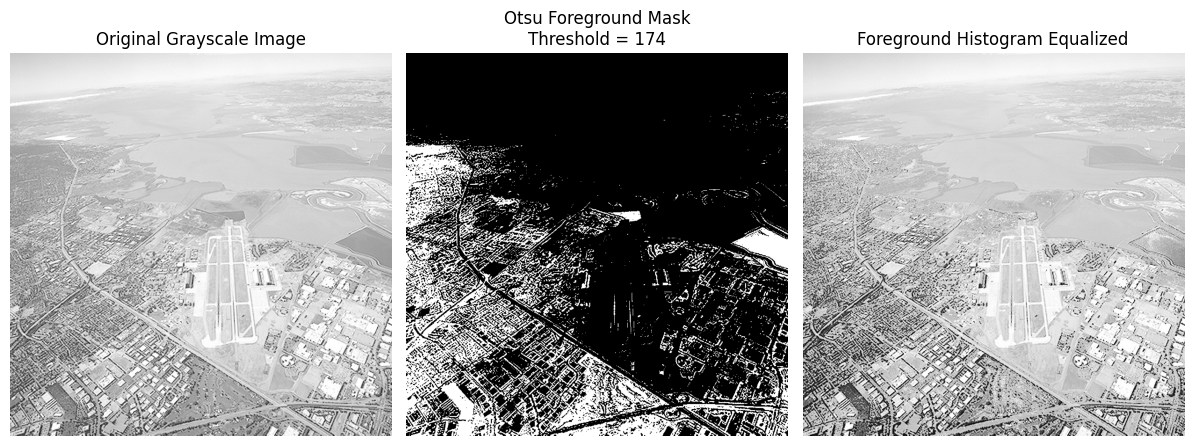

In [36]:
# Load image from GitHub and convert to grayscale
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/runway.png"

img_rgb = load_image_from_github(url, grayscale=False)
img = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)

# (a) Otsu Thresholding (foreground = woman + room)
otsu_threshold, mask = cv.threshold(
    img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU
)

print("Otsu Threshold Value:", otsu_threshold)

# (b) Histogram Equalization on Foreground Only
foreground_pixels = img[mask == 255]

hist = np.bincount(foreground_pixels, minlength=256)
cdf = hist.cumsum()

cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')

img_equalized = img.copy()
img_equalized[mask == 255] = cdf_final[img[mask == 255]]

# Visualization
plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap="gray")
plt.title(f"Otsu Foreground Mask\nThreshold = {otsu_threshold:.0f}")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img_equalized, cmap="gray")
plt.title("Foreground Histogram Equalized")
plt.axis("off")

plt.tight_layout()
plt.show()


Q5)

Compute a normalized 5×5 Gaussian kernel (σ = 2)

In [37]:
# (a) Normalized 5×5 Gaussian kernel using NumPy

def gaussian_kernel(size, sigma):
    k = size // 2
    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

kernel_5x5 = gaussian_kernel(5, sigma=2)

kernel_5x5


array([[0.02324684, 0.03382395, 0.03832756, 0.03382395, 0.02324684],
       [0.03382395, 0.04921356, 0.05576627, 0.04921356, 0.03382395],
       [0.03832756, 0.05576627, 0.06319146, 0.05576627, 0.03832756],
       [0.03382395, 0.04921356, 0.05576627, 0.04921356, 0.03382395],
       [0.02324684, 0.03382395, 0.03832756, 0.03382395, 0.02324684]])

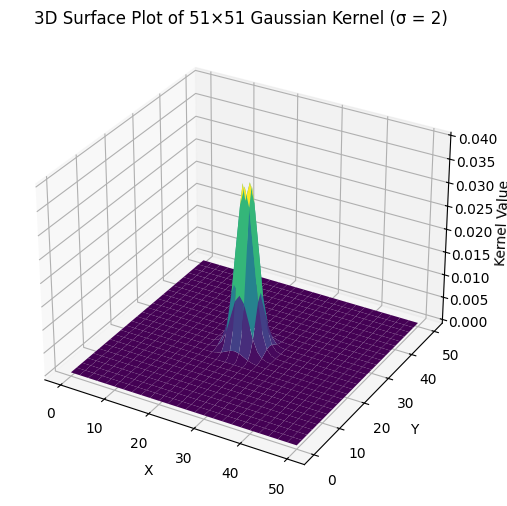

In [38]:
# (b) 3D visualization of 51×51 Gaussian kernel

kernel_51 = gaussian_kernel(51, sigma=2)

x = np.arange(51)
y = np.arange(51)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, kernel_51, cmap='viridis')

ax.set_title("3D Surface Plot of 51×51 Gaussian Kernel (σ = 2)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Kernel Value")

plt.show()


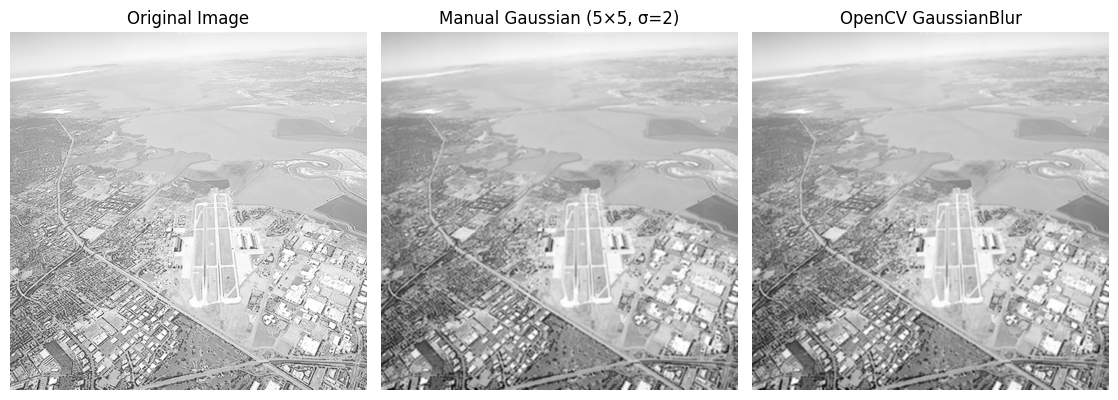

In [39]:
# Load grayscale image
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/runway.png"
img = load_image_from_github(url, grayscale=True)

# Manual Gaussian smoothing
kernel_5x5 = gaussian_kernel(5, sigma=2)
img_manual = cv.filter2D(img, -1, kernel_5x5)

# OpenCV Gaussian smoothing
img_opencv = cv.GaussianBlur(img, (5, 5), sigmaX=2)

# Visualization (3 subplots)
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(img_manual, cmap='gray')
plt.title("Manual Gaussian (5×5, σ=2)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img_opencv, cmap='gray')
plt.title("OpenCV GaussianBlur")
plt.axis("off")

plt.tight_layout()
plt.show()


Q6)

(b) — 5×5 Derivative-of-Gaussian Kernels (σ = 2)

In [40]:
def dog_kernels(size, sigma):
    k = size // 2
    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    
    G = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    G /= G.sum()
    
    Gx = -x / (sigma**2) * G
    Gy = -y / (sigma**2) * G
    
    return Gx, Gy

Gx_5, Gy_5 = dog_kernels(5, sigma=2)

Gx_5, Gy_5


(array([[ 0.01162342,  0.00845599,  0.        , -0.00845599, -0.01162342],
        [ 0.01691198,  0.01230339,  0.        , -0.01230339, -0.01691198],
        [ 0.01916378,  0.01394157,  0.        , -0.01394157, -0.01916378],
        [ 0.01691198,  0.01230339,  0.        , -0.01230339, -0.01691198],
        [ 0.01162342,  0.00845599,  0.        , -0.00845599, -0.01162342]]),
 array([[ 0.01162342,  0.01691198,  0.01916378,  0.01691198,  0.01162342],
        [ 0.00845599,  0.01230339,  0.01394157,  0.01230339,  0.00845599],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00845599, -0.01230339, -0.01394157, -0.01230339, -0.00845599],
        [-0.01162342, -0.01691198, -0.01916378, -0.01691198, -0.01162342]]))

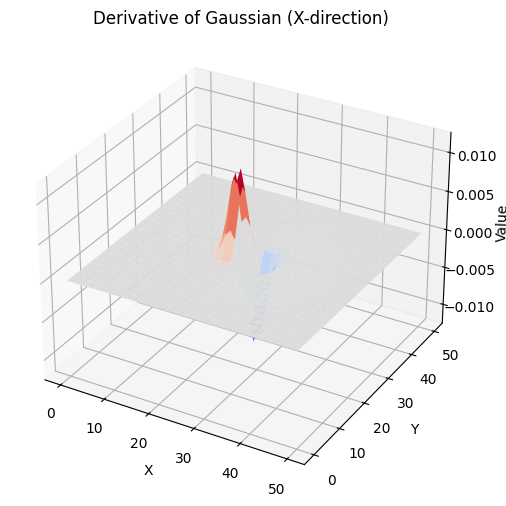

In [41]:
Gx_51, _ = dog_kernels(51, sigma=2)

x = np.arange(51)
y = np.arange(51)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Gx_51, cmap='coolwarm')

ax.set_title("Derivative of Gaussian (X-direction)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Value")

plt.show()


Manual DoG vs Sobel

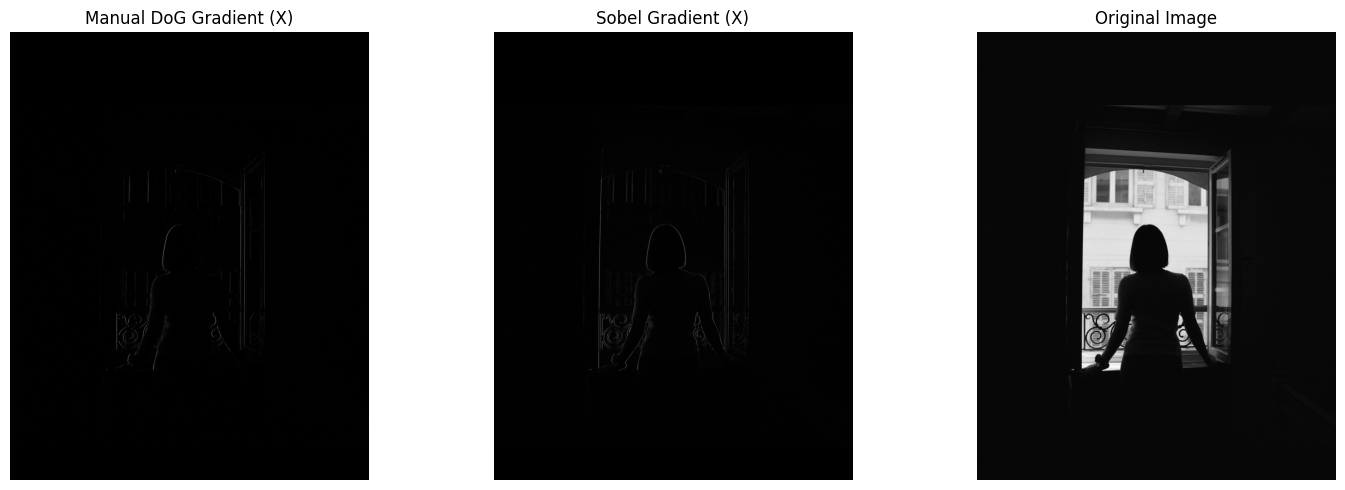

In [44]:
# Load grayscale image
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/looking_out.jpg"
img = load_image_from_github(url, grayscale=True)

# Manual DoG gradients
grad_x_manual = cv.filter2D(img, -1, Gx_5)
grad_y_manual = cv.filter2D(img, -1, Gy_5)

# Sobel gradients
grad_x_sobel = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
grad_y_sobel = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.abs(grad_x_manual), cmap="gray")
plt.title("Manual DoG Gradient (X)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.abs(grad_x_sobel), cmap="gray")
plt.title("Sobel Gradient (X)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.tight_layout()
plt.show()


Q7)

In [49]:
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im01.png"
im01 = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im01small.png"
im01small = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im02.png"
im02 = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im02small.png"
im02small = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im03.png"
im03 = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im03small.png"
im03small = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/taylor.jpg"
taylor = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/taylor_small.jpg"
taylor_small = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/taylor_very_small.jpg"
taylor_very_small = load_image_from_github(url, grayscale=True)



In [50]:
def zoom_image(img, scale, method="nn"):
    h, w = img.shape
    new_h, new_w = int(h * scale), int(w * scale)
    out = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            x = i / scale
            y = j / scale

            if method == "nn":
                xi = min(int(round(x)), h - 1)
                yj = min(int(round(y)), w - 1)
                out[i, j] = img[xi, yj]

            elif method == "bilinear":
                x0 = int(np.floor(x))
                y0 = int(np.floor(y))
                x1 = min(x0 + 1, h - 1)
                y1 = min(y0 + 1, w - 1)

                dx = x - x0
                dy = y - y0

                out[i, j] = (
                    (1 - dx) * (1 - dy) * img[x0, y0] +
                    dx * (1 - dy) * img[x1, y0] +
                    (1 - dx) * dy * img[x0, y1] +
                    dx * dy * img[x1, y1]
                )

    return np.uint8(out)


In [51]:
def normalized_ssd(img1, img2):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    return np.sum((img1 - img2) ** 2) / img1.size


Normalized SSD (Nearest Neighbor): 256.82233
Normalized SSD (Bilinear): 201.44933


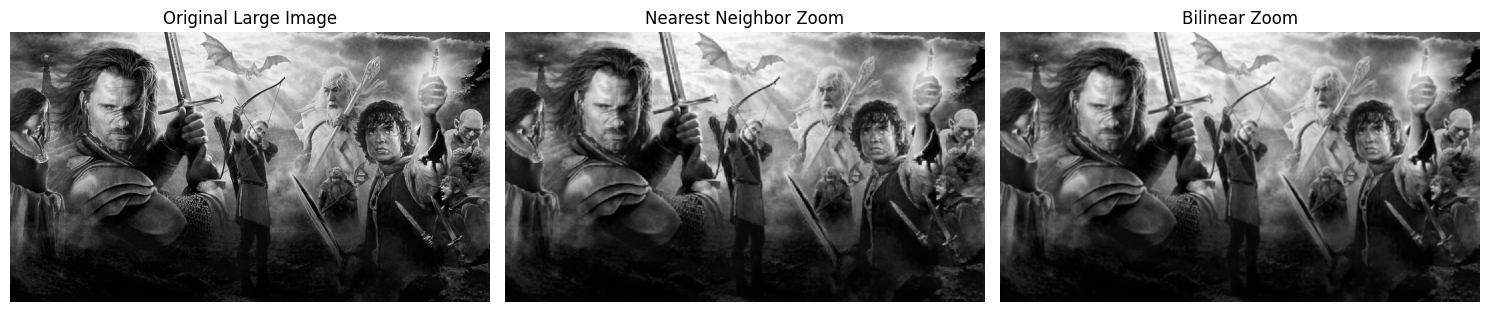

In [52]:
# Select image pair
img_large = im01
img_small = im01small

# Compute scale factor
scale = img_large.shape[0] / img_small.shape[0]

# Zoom using both methods
zoom_nn = zoom_image(img_small, scale, method="nn")
zoom_bl = zoom_image(img_small, scale, method="bilinear")

# Compute SSD
ssd_nn = normalized_ssd(img_large, zoom_nn)
ssd_bl = normalized_ssd(img_large, zoom_bl)

print("Normalized SSD (Nearest Neighbor):", ssd_nn)
print("Normalized SSD (Bilinear):", ssd_bl)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_large, cmap="gray")
plt.title("Original Large Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(zoom_nn, cmap="gray")
plt.title("Nearest Neighbor Zoom")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(zoom_bl, cmap="gray")
plt.title("Bilinear Zoom")
plt.axis("off")

plt.tight_layout()
plt.show()


Normalized SSD (Nearest Neighbor): 0.0
Normalized SSD (Bilinear): 0.0


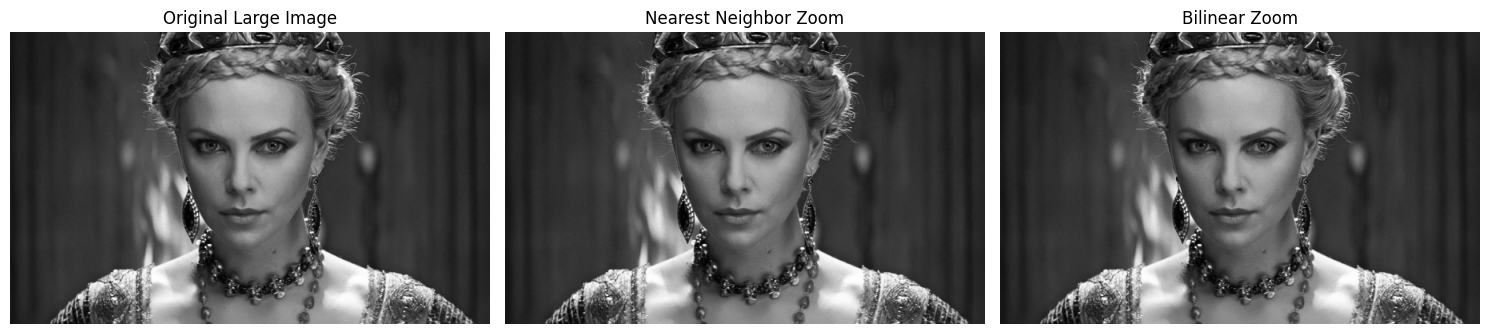

In [56]:
# Select image pair
img_large = im03small
img_small = im03small

# Compute scale factor
scale = img_large.shape[0] / img_small.shape[0]

# Zoom using both methods
zoom_nn = zoom_image(img_small, scale, method="nn")
zoom_bl = zoom_image(img_small, scale, method="bilinear")

# Compute SSD
ssd_nn = normalized_ssd(img_large, zoom_nn)
ssd_bl = normalized_ssd(img_large, zoom_bl)

print("Normalized SSD (Nearest Neighbor):", ssd_nn)
print("Normalized SSD (Bilinear):", ssd_bl)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_large, cmap="gray")
plt.title("Original Large Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(zoom_nn, cmap="gray")
plt.title("Nearest Neighbor Zoom")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(zoom_bl, cmap="gray")
plt.title("Bilinear Zoom")
plt.axis("off")

plt.tight_layout()
plt.show()


Q8)

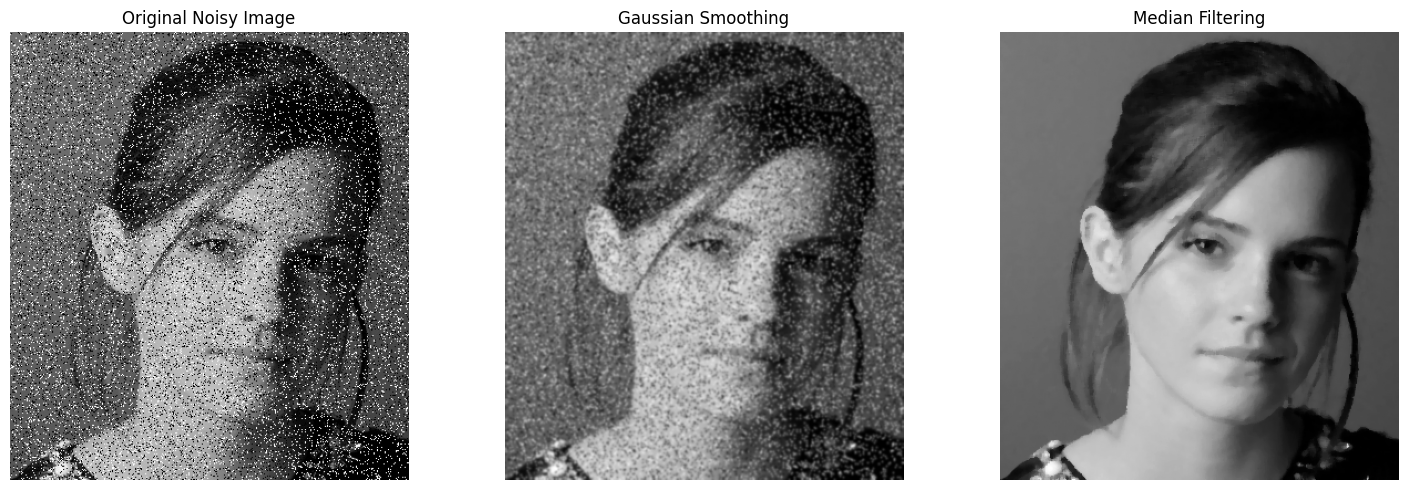

In [7]:
# Load salt & pepper noise image (Fig. 4)
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/emma_salt_pepper (1).jpg"
img_sp = load_image_from_github(url, grayscale=True)

# (a) Gaussian smoothing
img_gaussian = cv.GaussianBlur(img_sp, (5, 5), sigmaX=1)

# (b) Median filtering
img_median = cv.medianBlur(img_sp, 5)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_sp, cmap="gray")
plt.title("Original Noisy Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_gaussian, cmap="gray")
plt.title("Gaussian Smoothing")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_median, cmap="gray")
plt.title("Median Filtering")
plt.axis("off")

plt.tight_layout()
plt.show()


Q9)

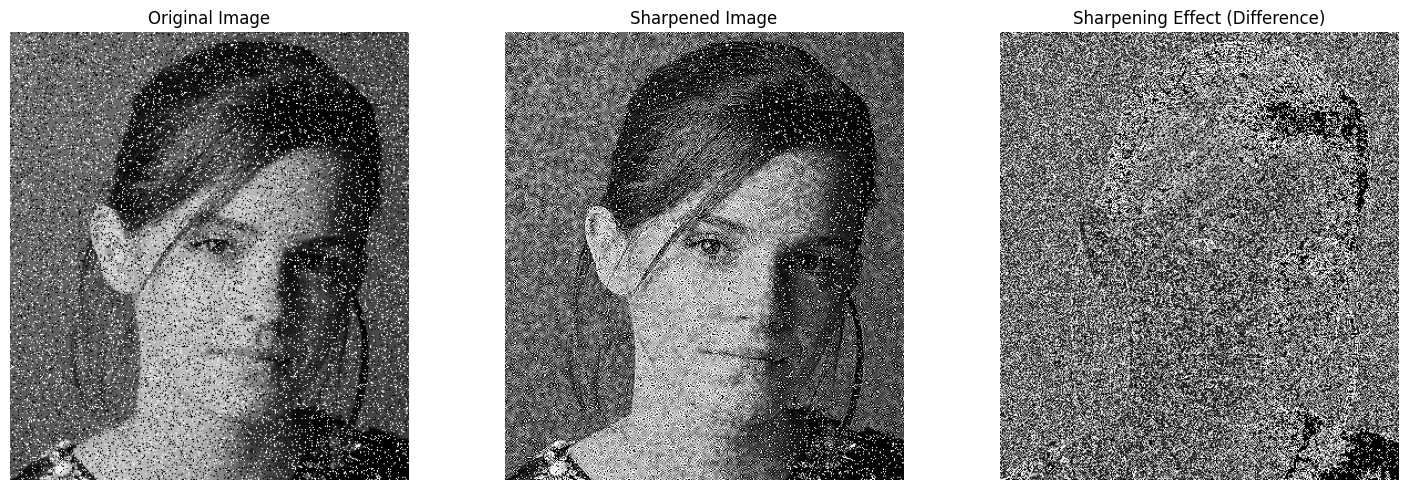

In [8]:
# Use the noisy image from Q8
img = img_sp.copy()

# Sharpening kernel (unsharp mask / high-boost)
sharpen_kernel = np.array([
    [0, -1,  0],
    [-1, 5, -1],
    [0, -1,  0]
])

# Apply sharpening
img_sharpened = cv.filter2D(img, -1, sharpen_kernel)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_sharpened, cmap="gray")
plt.title("Sharpened Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(img_sharpened - img), cmap="gray")
plt.title("Sharpening Effect (Difference)")
plt.axis("off")

plt.tight_layout()
plt.show()


Q10)

(a) — Manual Bilateral Filter (Grayscale)

In [9]:
def bilateral_filter_manual(img, d, sigma_s, sigma_r):
    k = d // 2
    padded = np.pad(img, k, mode='edge')
    output = np.zeros_like(img, dtype=np.float32)

    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    spatial = np.exp(-(x**2 + y**2) / (2 * sigma_s**2))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+d, j:j+d]
            range_kernel = np.exp(-(region - img[i, j])**2 / (2 * sigma_r**2))
            weights = spatial * range_kernel
            output[i, j] = np.sum(weights * region) / np.sum(weights)

    return np.uint8(output)


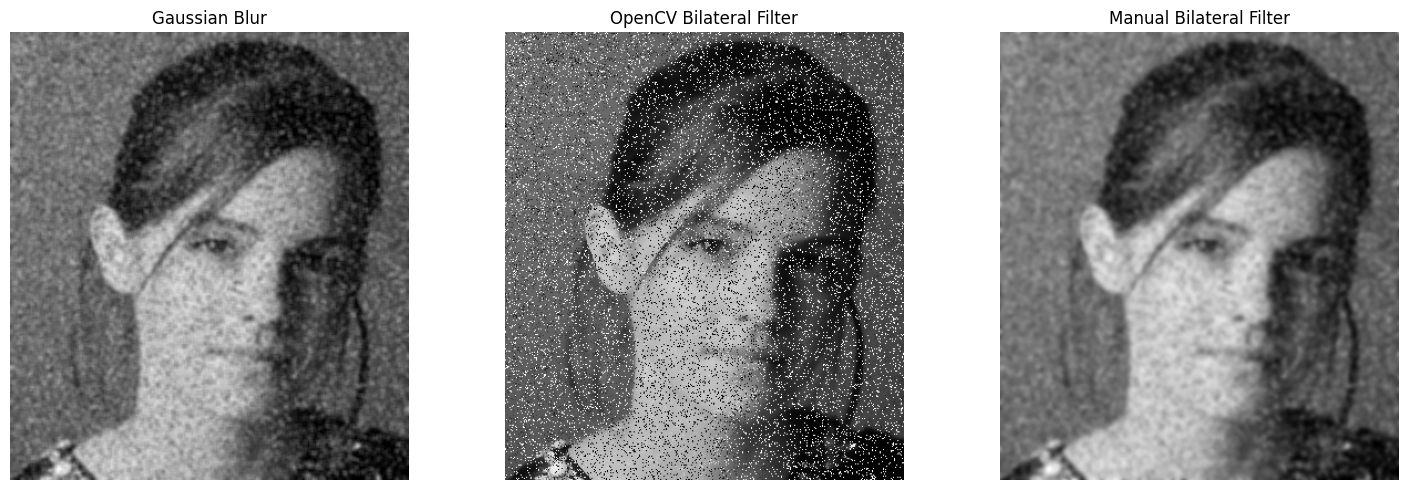

In [10]:
# (b) Gaussian smoothing
img_gaussian = cv.GaussianBlur(img, (5, 5), sigmaX=2)

# (c) OpenCV bilateral filter
img_bilateral_cv = cv.bilateralFilter(img, d=9, sigmaColor=50, sigmaSpace=50)

# (d) Manual bilateral filter
img_bilateral_manual = bilateral_filter_manual(img, d=9, sigma_s=2, sigma_r=50)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_gaussian, cmap="gray")
plt.title("Gaussian Blur")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_bilateral_cv, cmap="gray")
plt.title("OpenCV Bilateral Filter")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_bilateral_manual, cmap="gray")
plt.title("Manual Bilateral Filter")
plt.axis("off")

plt.tight_layout()
plt.show()
